# Random Forest in Python (from scratch)

[Video](https://www.youtube.com/watch?v=O5F9vR2CNYI&feature=youtu.be)

Exercise writing a RF in Python.
For testing we compare it to an existing RF implementation.
When doing non-trivial amounts of code  in ML, 
it is hard to know whether we've got it right or wrong.
Assume we erred at every step and we need to figure out how.
In ML there are many ways to get things wrong that don't give an error, 
they just make the result less good.

To compare to an existing implementation we use the existing data set and validation set.
To simplify, we only use two columns.
<br>
Lets top-down start by assuming that everything we want already exists.

In [1]:
%pwd

'/home/german/DeepLearning/ML'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

#from fastai.imports import *
#from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

## Load in our data from last lesson

In [4]:
import pandas as pd
from fastai.structured import proc_df

PATH = "/data/bulldozers/"

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [5]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

To simplify, we just have 2 variables (columns)

In [6]:
x_sub = X_train[['YearMade', 'MachineHoursCurrentMeter']]

## Basic data structures

Create a TreeEnsemble class.
To create a RF the first question is, what do we need to pass to `__in__`:
- `x` independent variable, 
- `y` dependent variable,
- `n_trees` to pick how many trees we use,
- `sample_sz` parameter for how big is each sample,
- `min_leaf` as an optional parameter of the smallest leaf size.

For testing we use a constant random seed, 42, so we'll get the same result each time.<br>
First draws a random sample of indexes without replacement.
A tree is returned which includes only the specific indexes.   
All the randomness happens at the `TreeEnsemble` class.
<br>
An RF is something that creates some trees.
We make a list comprehension to create a list of `n_trees` trees, calling `create_tree()`

We need a `predict()` function:
For a particular row (or number of rows) go through each tree `t` 
and calculate its prediction, then take the mean.
**NB:** `predict` is **not** recursive, it invokes `t.predict()` which we have not yet defined. <br>
We can pass to `np.mean` a regular list, by just telling it `axis=0`, 
which  means average it across the lists.
<br>
To `create_tree` in an RF we could pick some random IDs.<br>
**NB: idiom** We call `np.random.permutation(n)`, 
returns a randomly shuffled sequence from 0 to $n$.  
(a faster alternative would be to use `np.random.choice()`.)
We then take the first `:self.sample_sz` items as a random subsample.
This is not doing bootstrapping we're not doing sampling with replacement for this RF.

In [7]:
import numpy as np

In [8]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        rnd_idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[rnd_idxs], self.y[rnd_idxs], min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)  # invokes tree.predict()

### DecisionTree
We pass to the `DecisionTree __init__` everything we got for constructing the RF, except `n_trees`.
- a random sample of `x`'s and `y`'s.
- `idxs` indexers, as a decision tree contain decision trees, etc., there's going to be a subset of the original data.
So we pass the indexes of the data that we're going to use each time. <br>
Initially it's the entire random sample, so we have the whole range and we turn it an array.
- `min_leaf_size`.
<br>
We store all inside the object.
We need to know how many rows (`self.n`) and columns (`self.c`) are in this tree.
- `self.n` is equal to the number of indexes given,
- `self.c` is the number of columns in the independent variables, i.e., `x.shape[1]`.
<br>
Then we need to know the tree's prediction:
the mean of our dependent variable for those indexes 
which are inside this part of the tree.
<br>
At the very top of the tree it contains all the indexes.
```
if idxs is None: idxs=np.arange(len(y))
```
All the random sampling is done, the indexes are the random sample to create the tree. 
Now we're building a plain old decision tree.
Every leaf and every node in a tree has a value,
a prediction that is equal to the average of the dependent variable.
```
self.val = np.mean(y[idxs])
```
Some nodes (non-leafs) in a tree also have a score, how effective was the split.
A leaf node has no further splits, and at this point when we create a tree
we haven't done any splits yet.
So it's score starts out as being infinity.
```
self.score = float('inf')
```
Next `self.find_varsplit()` 
will find which variable to split on,
and what level of that variable should we split on. 
How do we find a variable to split on?
We can go through each potential variable and find a better one.
```
for i in range(self.c): self.find_better_split(i)
```

In [9]:
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs]) # mean of all the dependent variables at the top
        self.score = float('inf')
        self.find_varsplit()
        
    # This just does one decision; we'll make it recursive later
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
            
    # We'll write this later!
    def find_better_split(self, var_idx): pass
    
    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self): 
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

To get a good descriptive representation of the class, 
we need to implement the ` __repr__` method.
<br>
We create a format string where we print out `n` and show `n`,
(how many rows in this node),
then print `val` and show `val` (the average of the dependent variable).
<br>
If it's not a leaf node, it has a split. 
Then we should print the score, the value we split out, 
and the variable that we split on.
<br>
**NB:** `self.is_leaf` is defined as a method but there are no parentheses after it.
This is a special kind of method code `property`.
`property` looks like a regular variable but it's actually calculated on the fly.
When we call `is_leaf` it calls the function, which has a special decorator `@property`.

In [10]:
m = TreeEnsemble(X_train, y_train, n_trees=10, sample_sz=1000, min_leaf=3)

In [12]:
m.trees[0]   # Now will print something since we have added the @property decorators and the __repr__

n: 1000; val:10.079014121552744

In [13]:
m.trees[0].idxs

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,
        20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,
        60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159,
       160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 

## Single branch

###  Find best split given variable
Lets do it first using the scikit library to later compare our results.
We must ensure that this RF gets exactly the same data that we have.
We start by creating ensemble, grab a tree out of it.
Then we find out which particular random sample of `x` and `y` 
did this tree use.
We store them away so that we can pass them to scikit-learn so we have exactly
the same information.

In [14]:
ens = TreeEnsemble(x_sub, y_train, 1, 1000)
tree = ens.trees[0]
x_samp,y_samp = tree.x, tree.y
x_samp.columns

Index(['YearMade', 'MachineHoursCurrentMeter'], dtype='object')

In [15]:
tree

n: 1000; val:10.079014121552744

Now we create a RF using the scikit-learn library,
one tree, one decision, no bootstrapping (the whole data set).
This should be exactly the same as what we're going to create.

In [17]:
m = RandomForestRegressor(n_estimators=1, max_depth=1, bootstrap=False)
m.fit(x_samp, y_samp)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=1,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

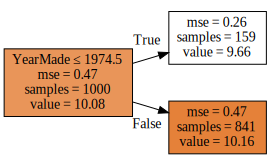

In [18]:
from fastai.structured import draw_tree
draw_tree(m.estimators_[0], x_samp, precision=2)

We define `find_better_split`.
Let's define our `x` and `y` variables.
```
x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
``` 
`x` is everything inside our tree but only those indexes that are in this node
(at the top of the tree is everything), and the one variable being passed, `var_idx`.
<br>
For `y` it's just whatever a dependent variable is at the indexes in this node.

Now go through every single value in our independent variable.
```
for i in range(1,self.n-1):
```



In [19]:
def find_better_split(self, var_idx):
    x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]

    for i in range(1,self.n-1):
        lhs = x<=x[i]
        rhs = x>x[i]
        if rhs.sum()==0: continue
        lhs_std = y[lhs].std()
        rhs_std = y[rhs].std()
        curr_score = lhs_std*lhs.sum() + rhs_std*rhs.sum()
        if curr_score<self.score: 
            self.var_idx,self.score,self.split = var_idx,curr_score,x[i]

Above is $O(n^2)$ complexity, as it has a loop $O(n)$ and inside the loop we have a linear search for the bigger and smaller values.. will improve below by sorting the data.

In [20]:
%timeit find_better_split(tree,1)
tree

103 ms ± 130 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


n: 1000; val:10.079014121552744; score:681.0184057251435; split:3744.0; var:MachineHoursCurrentMeter

In [21]:
find_better_split(tree,0); tree

n: 1000; val:10.079014121552744; score:658.5510186055949; split:1974.0; var:YearMade

### Speeding things up
We sort the data and then keep track of some of `x` and some of $x^2$.
So we can turn this into a $O(n)$ algorithm.

In [22]:
tree = TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]

In [23]:
import math

In [24]:
def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

def find_better_split_foo(self, var_idx):
    x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
    
    sort_idx = np.argsort(x)
    sort_y,sort_x = y[sort_idx], x[sort_idx]
    rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
    lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

    for i in range(0,self.n-self.min_leaf-1):
        xi,yi = sort_x[i],sort_y[i]
        lhs_cnt += 1; rhs_cnt -= 1
        lhs_sum += yi; rhs_sum -= yi
        lhs_sum2 += yi**2; rhs_sum2 -= yi**2
        if i<self.min_leaf or xi==sort_x[i+1]:
            continue
            
        lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
        rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
        curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
        if curr_score<self.score: 
            self.var_idx,self.score,self.split = var_idx,curr_score,xi

In [25]:
%timeit find_better_split_foo(tree,1)
tree   # and check the results did  not change.

1.61 ms ± 2.23 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


n: 1000; val:10.079014121552744; score:681.0184057251353; split:3744.0; var:MachineHoursCurrentMeter

Check below that the numbers of the faster implementation are the same as above.

In [26]:
find_better_split_foo(tree,0); tree

n: 1000; val:10.079014121552744; score:658.5510186055565; split:1974.0; var:YearMade

Now we want to insert the faster implementation into the decision tree class.
Python does everything dynamically, so we can assign to the method of the class.
```
DecisionTree.find_better_split = find_better_split_foo
```
What's slightly confusing about this is that the right side
name has no relationship to the left side. 
That is why we added the `_foo` postfix to avoid confusions (but not needed).


In [27]:
DecisionTree.find_better_split = find_better_split_foo

In [28]:
tree = TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]; tree

n: 1000; val:10.079014121552744; score:658.5510186055565; split:1974.0; var:YearMade

## Full single tree

First (again) do it with the library of scikit to later be able to compare our results.

In [29]:
m = RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False)
m.fit(x_samp, y_samp)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

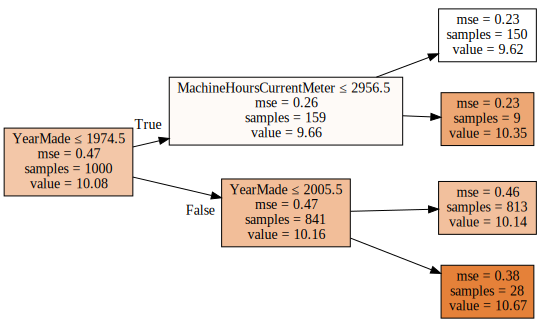

In [30]:
draw_tree(m.estimators_[0], x_samp, precision=2)

Now elaborate `find_varsplit` so it is recursive, by calling `DecisionTree` on the left and right sides of the tree.
`np.nonzero(a)`: Return the indices of the elements that are non-zero.


In [31]:
def find_varsplit(self):
    for i in range(self.c): self.find_better_split(i)
    if self.is_leaf: return
    x = self.split_col
    lhs = np.nonzero(x<=self.split)[0]
    rhs = np.nonzero(x>self.split)[0]
    self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
    self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

Again, patch the new implementation into the class method.

In [32]:
DecisionTree.find_varsplit = find_varsplit

In [33]:
tree = TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]; tree

n: 1000; val:10.079014121552744; score:658.5510186055565; split:1974.0; var:YearMade

Now validate that they are the same as the scikit library results.

In [34]:
tree.lhs

n: 159; val:9.660892662981706; score:76.82696888346362; split:2800.0; var:MachineHoursCurrentMeter

In [35]:
tree.rhs

n: 841; val:10.158064432982941; score:571.4803525045031; split:2005.0; var:YearMade

In [36]:
tree.lhs.lhs

n: 150; val:9.619280538108496; score:71.15906938383463; split:1000.0; var:YearMade

In [37]:
tree.lhs.rhs

n: 9; val:10.354428077535193

## Predictions
A set of predictions for a tree is simply the prediction for a row for every row.
To make it more interesting, lets start bringing up the number of columns to 7 as below.

In [38]:
cols = ['MachineID', 'YearMade', 'MachineHoursCurrentMeter', 'ProductSize', 'Enclosure',
        'Coupler_System', 'saleYear']

In [39]:
%time tree = TreeEnsemble(X_train[cols], y_train, 1, 1000).trees[0]
x_samp,y_samp = tree.x, tree.y

CPU times: user 328 ms, sys: 4.01 ms, total: 332 ms
Wall time: 331 ms


We create a tree ensemble again, this time maximum depth of 3.

In [40]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False)
m.fit(x_samp, y_samp)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

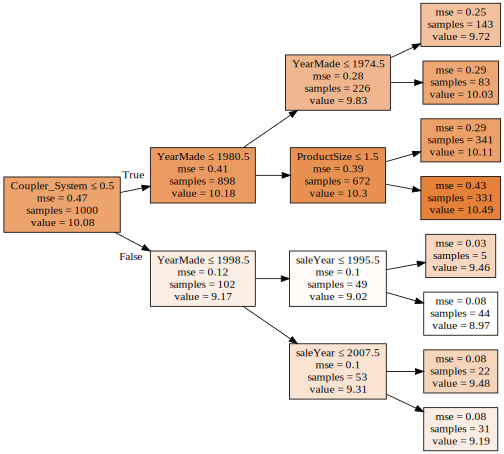

In [41]:

draw_tree(m.estimators_[0], x_samp, precision=2, ratio=0.9, size=7)

Define the predictions for a tree as the predictions for a row ( `.predict_row(xi)` for all the `xi` rows).
The comprehension (`for xi in x`) will go thru the leading axis (the vector itself).
NB: the comprehension works with an np.array regardless
of the rank of the array, ie  regardless of the number of axes in the array.
This will look through the **leading axis**.
(Very important for future neural networks tensor computations.)
- The leading axis of a:
    - vector is the vector itself.
    - matrix are the rows.
    - 3-dimensional tensor the matrices that represent the slices 

Here, `x` is a matrix so the comprehension will look through the rows,
this way then it will generalize nicely to higher dimensions.

In [42]:
def predict(self, x): return np.array([self.predict_row(xi) for xi in x])   # will go thru the leading axis (the vector itself)
DecisionTree.predict = predict

```
Python:
x = do1() if something else do2() 
is equivalent to C
x = something ? do1() : do2()
```

If we're at a leaf node, then the prediction is equal to the
value which we calculated in the original tree constructor.
If it's not a leaf node, then we have to figure out whether to go down the
left-hand path or the right-hand path to get the prediction,
depending on the amount we decided to split on.
```
t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
```
and again we've created something recursive, and assign it to the method in the class.


In [43]:
def predict_row(self, xi):
    if self.is_leaf: return self.val
    t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
    return t.predict_row(xi)

DecisionTree.predict_row = predict_row

Now we can do predictions... and then plot them.

In [44]:
%time preds = tree.predict(X_valid[cols].values)

CPU times: user 105 ms, sys: 37 µs, total: 105 ms
Wall time: 105 ms


Now we plot actuals against predictions.
In a scatter plot we often have a lot of dots on top of each other.
A good trick is to use `alpha`, i.e., how transparent things.
If `alpha = 0.05` then we need 20 dots on top of each other for it to be fully blue.

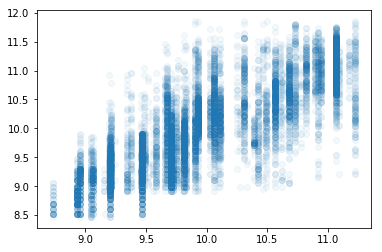

In [45]:
from matplotlib import pyplot as plt 
plt.scatter(preds, y_valid, alpha=0.05)   # alpha means how transparent, here .05 means need 20 dots to be a full blue dot

$R^2$ is not bad.

In [46]:
metrics.r2_score(preds, y_valid)

0.5037152213688234

Again we do the normal RF from skcit learn for comparing the $R^2$.

CPU times: user 3.83 ms, sys: 0 ns, total: 3.83 ms
Wall time: 3.51 ms


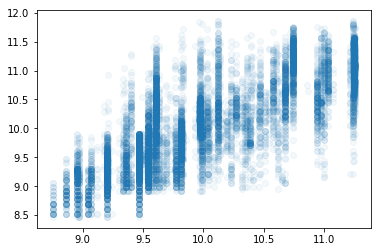

In [47]:
m = RandomForestRegressor(n_estimators=1, min_samples_leaf=5, bootstrap=False)
%time m.fit(x_samp, y_samp)
preds = m.predict(X_valid[cols].values)
plt.scatter(preds, y_valid, alpha=0.05)

Somehow our $R^2$ is better than this... its ok...

In [48]:
metrics.r2_score(preds, y_valid)

0.47541053100694797

# Putting it together
Below we "copy and paste" from above, without changes, to create a package.

In [49]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[idxs], self.y[idxs], 
                    idxs=np.array(range(self.sample_sz)), min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

In [50]:
class DecisionTree():
    def __init__(self, x, y, idxs, min_leaf=5):
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

In [51]:
ens = TreeEnsemble(X_train[cols], y_train, 5, 1000)

In [52]:
preds = ens.predict(X_valid[cols].values)

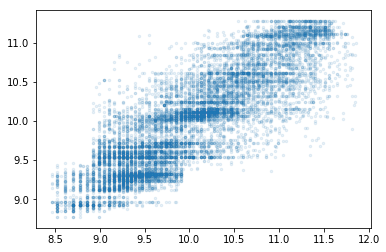

In [53]:
plt.scatter(y_valid, preds, alpha=0.1, s=6);

In [54]:
metrics.r2_score(y_valid, preds)

0.7101174157107124

# END